# Pylops - CUDA basic linear operators

### Author: M.Ravasi

In this notebook we will experiment with Pytorch to assess its usability as backend for CUDA enabled operators

In [1]:
!pip install pylops
!pip install git+https://git@github.com/equinor/pylops-gpu.git@master

     |████████████████████████████████| 143kB 2.7MB/s 
  Cloning https://git@github.com/equinor/pylops-gpu.git (to revision master) to /tmp/pip-req-build-196kumxa
  Running command git clone -q https://git@github.com/equinor/pylops-gpu.git /tmp/pip-req-build-196kumxa
  Stored in directory: /tmp/pip-ephem-wheel-cache-771h54q6/wheels/c7/f0/0b/513e9be2dad0cbe2a900c0414a94bcae8778093383364aab9a
  Stored in directory: /root/.cache/pip/wheels/12/9c/1c/35f0a149f864e1b4d5f0711bf76745aebef1f306fc8ab9ec40
Successfully built pylops-gpu pytorch-complex-tensor


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from scipy.sparse.linalg import cg
from pylops import Diagonal, MatrixMult
from pylops.utils import dottest
from pylops_gpu.utils.backend import device
from pylops_gpu.utils import dottest as gdottest
from pylops_gpu import Diagonal as gDiagonal

Populating the interactive namespace from numpy and matplotlib


In [3]:
dev = device()
print('PyLops-gpu working on %s...' % dev)

PyLops-gpu working on cuda...


## Diagonal

Example with model and data already on GPU

In [4]:
n = int(1e6)
xg = torch.ones(n, dtype=torch.float32).to(dev)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)

x = xg.cpu().numpy()
d = dg.cpu().numpy()

Dop = Diagonal(d)
Dop_gpu = gDiagonal(dg, device=dev)
dottest(Dop, n, n, verb=True)
gdottest(Dop_gpu, n, n, device=dev, verb=True)

# y = Dx
yg = Dop_gpu * xg
print('y', yg)

Dot test passed, v^T(Opu)=-22211585.991098 - u^T(Op^Tv)=-22211585.991098
Dot test passed, v^T(Opu)=124900892672.000000 - u^T(Op^Tv)=124900892672.000000
y tensor([1.0000e+00, 2.0000e+00, 3.0000e+00,  ..., 1.0000e+06, 1.0000e+06,
        1.0000e+06], device='cuda:0')


In [5]:
%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xg

10 loops, best of 3: 784 µs per loop
10 loops, best of 3: 18.4 µs per loop


Example with model and data transfered from and to gpu in forward and adjoint operations

Dot test passed, v^T(Opu)=125259546624.000000 - u^T(Op^Tv)=125259554816.000000
y tensor([1.0000e+00, 2.0000e+00, 3.0000e+00,  ..., 1.0000e+06, 1.0000e+06,
        1.0000e+06], device='cuda:0')


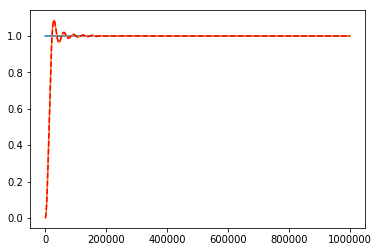

In [6]:
n = int(1e6)
xg = torch.ones(n, dtype=torch.float32).to(dev)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)

xc = xg.cpu()
x = xg.cpu().numpy()
d = dg.cpu().numpy()

Dop = Diagonal(d)
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True), tocpu=(True, True))
gdottest(Dop_gpu, n, n, verb=True)

# y = Dx
y = Dop_gpu * x
print('y', yg)

# xinv = D^-1 y
xinv = Dop / y
xinvg = Dop_gpu / y

plt.figure()
plt.plot(x)
plt.plot(xinv)
plt.plot(xinvg, '--r')

In [7]:
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True))

%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xc

10 loops, best of 3: 799 µs per loop
10 loops, best of 3: 726 µs per loop


In [8]:
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True), tocpu=(True, True))

%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xc

10 loops, best of 3: 818 µs per loop
10 loops, best of 3: 1.82 ms per loop


Note here how we get hit by the cost of moving x and y back and forth between CPU and GPU.

# 1D Convolution

In [9]:
N = 11
Nh = 3
x = np.zeros(N)
x[N//2] = 1

h = np.arange(Nh)+1
y = np.convolve(x, h, mode='same')
print(y)
print(y.shape)

[0. 0. 0. 0. 1. 2. 3. 0. 0. 0. 0.]
(11,)


In [10]:
xt = torch.zeros(N)
xt[N//2] = 1

ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.
yt = torch.torch.conv_transpose1d(xt.reshape(1, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt)
print(yt.shape)

tensor([[[0., 0., 0., 0., 1., 2., 3., 0., 0., 0., 0.]]])
torch.Size([1, 1, 11])


In [11]:
y = np.correlate(x, h, mode='same')
print(y)

yt = torch.torch.conv1d(xt.reshape(1, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt)
print(yt.shape)

[0. 0. 0. 0. 3. 2. 1. 0. 0. 0. 0.]
tensor([[[0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0.]]])
torch.Size([1, 1, 11])


In [12]:
xt = torch.zeros((1000, N))
xt[:, N//2] = 1
ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.

xc = xt.to(dev)
hc = ht.to(dev)

yt = torch.torch.conv1d(xt.reshape(1000, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt.shape)
yc = torch.torch.conv1d(xc.reshape(1000, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)
print(yc.shape)

% timeit torch.torch.conv1d(xt.reshape(1000, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
% timeit torch.torch.conv1d(xc.reshape(1000, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)

torch.Size([1000, 1, 11])
torch.Size([1000, 1, 11])
1000 loops, best of 3: 554 µs per loop
The slowest run took 4.51 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 64.5 µs per loop


## MatrixMult

In [0]:
def conjgrad_old(A, b, x0, niter):
    'Conjugate-gradient algorithm for minimizing |A x - dat|^2'
    x = x0
    r = b-A._matvec(x).ravel()
    d = r.copy()
    k = r.dot(r)
    k0 = k
    for iter in range(niter):
        a = r.dot(r) / d.dot(A._matvec(d).ravel())
        x = x + a*d
        rnew = r - a*A._matvec(d).ravel()
        k = rnew.dot(rnew)
        b = rnew.dot(rnew) / r.dot(r)
        d = rnew + b*d;
        r = rnew.copy()
    return x
  
def conjgrad(A, b, x, niter):
    'Conjugate-gradient algorithm for minimizing |A x - dat|^2'
    r = b - A._matvec(x)
    return x
    d = r.copy()
    kold = r.dot(r)
    for iter in range(niter):
        #if iter == 0:
        #  Ad = A._matvec(r)
        #  dAd = r.dot(Ad)
        #else:
        Ad = A._matvec(d)
        dAd = d.dot(Ad)
        a = kold / dAd
        x += a*d
        r -= a*Ad
        k = r.dot(r)
        b = k / kold
        d = r + b*d;
        kold = k
    return x
  
def conjgrad_gpu(A, b, x, niter):
    'Conjugate-gradient algorithm for minimizing |A x - dat|^2'
    #x = x0.clone()
    r = b - A.matmul(x)
    return x
    d = r.clone()
    kold = r.dot(r)
    for iter in range(niter):
        #if iter == 0:
        #  Ad = A.matmul(r)
        #  dAd = r.dot(Ad)
        #else:
        Ad = A.matmul(d)
        dAd = d.dot(Ad)
        a = kold / dAd
        x += a*d
        r -= a*Ad
        k = r.dot(r)
        b = k / kold
        d = r + b*d;
        #rold = r.clone()
        kold = k
    return x

In [78]:
n = 1000
niter = 100
x = np.ones(n)

A = np.random.randn(n, n)
ATA = np.dot(A.T, A)

Aop = MatrixMult(ATA)

y = Aop.matvec(x)
xinv_sp = cg(Aop, y, maxiter=niter)[0]
xinv_old = conjgrad_old(Aop, y, np.zeros_like(x), niter)
xinv = conjgrad(Aop, y, np.zeros_like(x), niter)

print(np.linalg.norm(xinv - xinv_sp))
print(np.linalg.norm(xinv - xinv_old))

0.00016837896551346847
0.0


7.752064498775677e-05


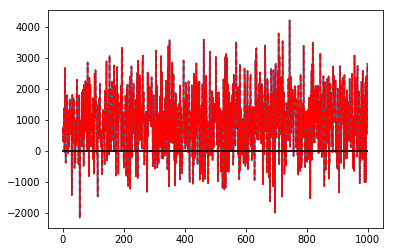

In [79]:
xg = torch.ones(n, dtype=torch.float64).to(dev)
x0g = torch.zeros(n, dtype=torch.float64).to(dev)
Ag = torch.from_numpy(A).to(dev)
ATAg = torch.matmul(Ag.t(), Ag)

yg = ATAg.matmul(xg)
plt.plot(y)
plt.plot(yg.cpu().numpy(), '--r')
plt.plot(y-yg.cpu().numpy(), 'k')

xinvg = conjgrad_gpu(ATAg, yg, torch.zeros(n, dtype=torch.float64).to(dev), niter)
print(np.linalg.norm(xinv - xinvg.cpu().numpy()))

plt.plot(x)
plt.plot(xinvg.cpu().numpy(), '--r')
plt.plot(x-xinvg.cpu().numpy(), 'k')

In [80]:
xgg = xg.reshape(n, 1)

%timeit -n 30 -r 3 ATA.dot(x)
%timeit -n 30 -r 3 ATAg.matmul(xg)
%timeit -n 30 -r 3 ATAg.mm(xgg)

30 loops, best of 3: 265 µs per loop
30 loops, best of 3: 17.3 µs per loop
30 loops, best of 3: 16.9 µs per loop


In [95]:
niter = 100

%timeit -n 2 cg(Aop, y, maxiter=niter)[0]
#%timeit -n 2 conjgrad_old(Aop, y, np.zeros_like(x), niter)
%timeit -n 2 conjgrad(Aop, y, np.zeros_like(x), niter)
%timeit -n 2 conjgrad_gpu(ATAg, yg, x0g, niter)

2 loops, best of 3: 148 ms per loop
2 loops, best of 3: 243 µs per loop
2 loops, best of 3: 40.8 µs per loop
